## Gene modules comparisons

## Needed data:
* ### Assignment of genes to modules (WGCNA / MFUZZ)    

We use WGCNA to cluster genes by their RNA activity in various TRNAseq experiments, both in developmental stages and pure tissue samples. This analysis assigns each gene in a single cluster. These clusters have names like "blue". "green" etc.
We manually explore the clusters, and by determining at which experiment the genes of the cluster seem to be differentially expressed (but also by GO analysis on each cluster), we assign more meaningful names to the clusters , like "liver", "muscle" etc. The translating dictionaries are in the end of the notebook.

* ### Assignment of genome regions to genes 
    
We assign a BASAL region to each gene, it starts from its TSS and extends 5kb upstream and 1kb downstream,
or untill it encounters another TSS.
    
* ### TF Motifs mapped in the genome
* ### Grouping of genes into homology-families       

In [1]:
import gzip
import os
import pysam

from pybedtools import BedTool as BT

%matplotlib inline
import seaborn as sns
sns.set_style('white')
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np

from collections import Counter
from functools import reduce
from operator import add


from scipy.stats import hypergeom
statf = hypergeom.sf
from math import log

from scipy.stats import pearsonr
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

from sklearn.preprocessing import scale, normalize, robust_scale
from sklearn.metrics.pairwise import pairwise_distances as PWD


import warnings
warnings.filterwarnings('ignore')

## Preprocessing:

In [2]:
# Here we load the mapping of genes to modules from csv
# into dictionaries:
dan_cl = pd.read_csv("./data/wgcna_results/wgcna_dre_modulekey.tab.gz", sep='\t')
dan_cl.columns = ['geneID','clusterID','updown']
dan_cl_d = dict(dan_cl[['geneID','clusterID']].to_records(index=False))
bla_cl = pd.read_csv("./data/wgcna_results/wgcna_bla_modulekey.tab.gz", sep='\t')
bla_cl.columns = ['geneID','clusterID','updown']
bla_cl_d = dict(bla_cl[['geneID','clusterID']].to_records(index=False))

# bla_cl_d ~= {'BL06687': 'greenyellow',
#  'BL12105': 'greenyellow',
#  'BL18033': 'magenta',....}

In [3]:
# we load the gene family bindings into a dictionary where 
# key = geneID
# value =  unique gene family number (some integer)
gfams = (pd
            .read_csv("./data/gene_families_table.tsv.gz",
                     sep='\t')
            .applymap(lambda c: c.split(':') if c==c else []))

gfamsC = gfams.applymap(lambda c: len(c))

gfamsD = {}
for rowi, row in gfams.iterrows():
    for species in ['Bla','Dre','Mmu','Hsa','Dme']:
        for gene in row[species]:
            gfamsD[gene] = int(rowi)
fam_of = {}
for rowi,row in gfams[['Bla']].dropna().iterrows():
    for gene in row.Bla:
        fam_of[gene]= rowi
for rowi,row in gfams[['Dre']].dropna().iterrows():
    for gene in row.Dre:
        fam_of[gene]= rowi
# fam_of maps all genes to their gene family ID

In [4]:
### translate the uninformative color names to manually made informative names for each module
### Cleaner versions of these dictionaries at the bottom of the notebook
transA = {'black' : '32 cells','blue' : 'N.tube(neurotrans.)','brown' : 'Gills','cyan' : 'N.tube(neurogen.)','darkmagenta' : 'Ovary/ Testis(translation)','darkorange' : 'Cilium','darkred' : 'Muscle','darkseagreen4' : '8-36hpf embryo/ Skin/ Cirri(memb. synt.)','darkslateblue' : '8hpf embryo(transcription, spliceosome)','darkturquoise' : '36hpf embryo','green' : 'Eggs/ 32 cells(cell cycle)','greenyellow' : 'Hepatic(lipid catabolism)','lavenderblush3' : 'Cirri / PreMet. / Muscle - actomyosin','lightpink4' : '15hpf embryo','magenta' : 'Skin','navajowhite2' : 'Immune','palevioletred3' : 'Ovary/ Eggs','pink' : 'Gut','plum1' : 'Gut/ Hepatic','plum2' : 'Proteasome','red' : 'PreMet.larvae','salmon' : 'Cirri(memb. synt.)','sienna3' : 'Hepatic','thistle2' : 'Gills/ PreMet larvae',
'turquoise' : 'Mitochondrion'}
transZ = {'bisque4' : "larvae 7d melanin",'black' : "Ovary/ Sperm",'blue' : "Brain",'brown' : "Cilium",'brown4' : "Liver(carboxi.met./ lipid trans)",'coral2' : "Mitochondrion",'darkgreen' : "Intestine",'darkgrey' : "RNA, ribosome, proteasome",'darkmagenta' : "Translation, ribosome, RNA bin.",'darkorange' : "Muscle",'darkred' : "Liver(oxi-red.proc./ hemostasis)",'darkseagreen4' : "12-26hpf embryo/ Skin",'darkslateblue' : "Immune",'green' : "Spliceosome",'honeydew1' : "12-26hpf embryo",'ivory' : "Eye",'lightcyan' : "Heart",'lightgreen' : "Pancreas/ Testis",'magenta' : "Gills",'pink' : "Skin",
    'salmon' : "20-26hpf embryo",'yellow4' : "Kidney",
'yellowgreen' : "Gills/ Skin"}

In [5]:
# We compute the upper tail of the hypergeometric distribution
# (survival function) for each pair of modules as a metric of enrichment

gimme_fams = lambda g: [fam_of.get(x) for x in g.geneID.tolist()]
# Population size:
gene_POP = len(gfams)

PVS = pd.DataFrame()
# for each module in zebra
for gn,g  in dan_cl.groupby('clusterID'):
    # for each module in amphioxus:
    for bgn,bg  in bla_cl.groupby('clusterID'):
        
        fams = set(gimme_fams(g))
        bfams = set(gimme_fams(bg))
        
        gene_SS = len(fams) # Sample Size
        gene_SIP = len(bfams) # Success in Population
        gene_SIS = len(bfams.intersection(fams)) # success in sample
        
        if gene_SIS>0:
            # statf is the survival function of the hypergeometric distribution            
            fish = statf(gene_SIS,  gene_POP,  gene_SS, gene_SIP)
        else:
            fish =1 
            
        PVS.loc[transZ[gn], transA[bgn]] = fish
        
# the translating dictionaries are at the end of the notebook

## The gene-based heatmap

In [6]:
# we get the -log transformation of the pvalues, clip them to a workable range
mPVS = PVS.applymap(lambda x: -log(x,10) ).copy().clip(upper=25,lower=0)

# We will compute the clustering outselves in order to be able to re-use it,
# and to have better control
# we cluster by row and by column, based on euclidean distance and complete method:
linkage_HG_rows = hc.linkage(sp.distance.squareform(PWD(  mPVS.values, metric='euclidean'), checks=False), method='complete')
linkage_HG_cols = hc.linkage(sp.distance.squareform(PWD(  mPVS.T.values, metric='euclidean'), checks=False), method='complete')

# Calculating the clustering like this, allows us to use the same clustering later on

Text(0.5,1,'Enrichment for orthologous genes')

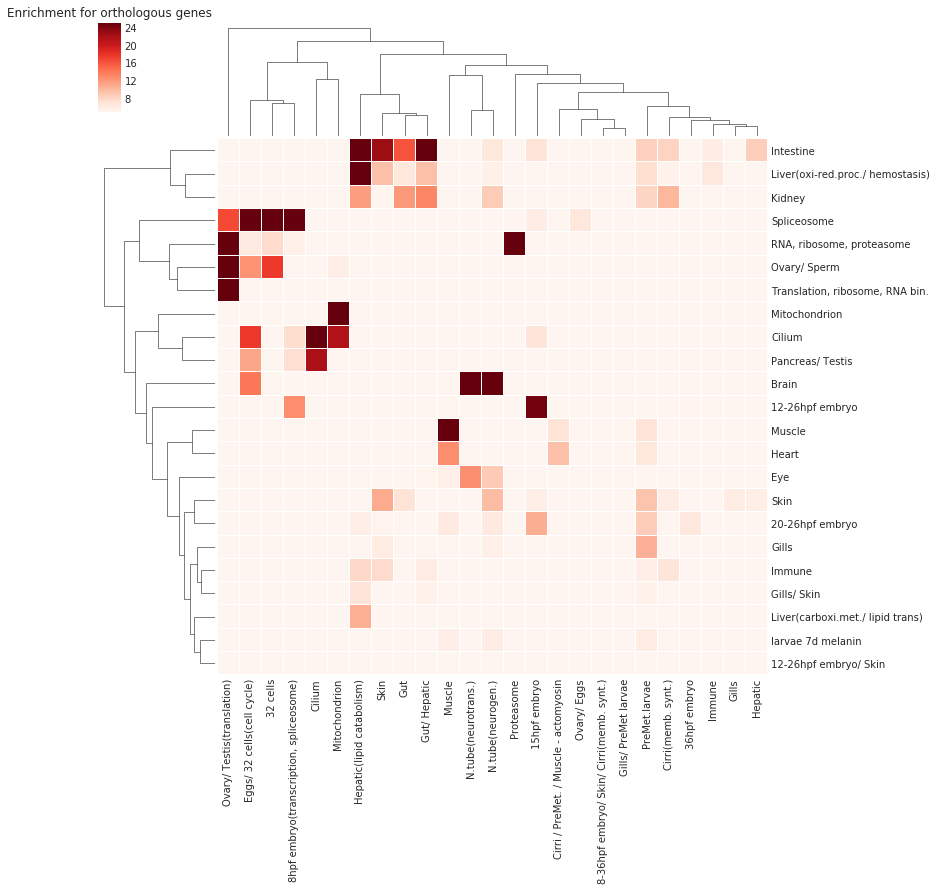

In [7]:
# Finally we plot this as a clustered heatmap
geneHM = sns.clustermap( mPVS,
                      row_linkage = linkage_HG_rows,
                      col_linkage = linkage_HG_cols,
                      linewidths=0.01,
                      figsize =(12,12),
                      cmap='Reds',
                      vmax=25, vmin=5

                      )

_ = plt.setp(geneHM.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.title('Enrichment for orthologous genes')

## We now want to map PWMs to modules

To do this, we will use the BASAL region of genes:

In [8]:
# gene to "gene region" connection
# This dataframe connects each gene to a genomic region:
dan_greg = pd.read_csv("./data/genomic_regions/BASAL_dre.bed.gz", sep='\t', header=None)
dan_greg.columns = ['chrom','start','end','geneID','strand']
dan_greg['score'] = 0
dan_greg = dan_greg[['chrom','start','end','geneID','score','strand']]

bla_greg = pd.read_csv("./data/genomic_regions/BASAL_bla.bed.gz", sep='\t', header=None)
bla_greg.columns = ['chrom','start','end','geneID','strand']
bla_greg['score'] = 0
bla_greg = bla_greg[['chrom','start','end','geneID','score','strand']]

and of course the PWMs that have been mapped on ATACseq peaks already:

In [9]:
# load the PWM hits in a pybedtools object and sort
dan_motif_bed = BT("./data/danre_pwm_hits.bed.gz").sort()
bla_motif_bed = BT("./data/bralan_pwm_hits.bed.gz").sort()

amphi_stages = ['8','15','36','60','hep']
zebra_stages = ['dome','shield','80epi','8som','24h','48h']

We also need the following table, which assigns a unique id number to each PWM.

In [10]:
# busy-work to assign unique IDs to each PWM family
superfams = pd.read_csv("./data/PWMname_to_ProteinFamily.tsv.gz", sep='\t', header=None)
def order_things(x):
    return ';'.join(sorted(x.split(';')))
lot = []
for i,row in superfams.iterrows():
    if ';' not in row[1]:
        lot.append( row.tolist() )
    else:
        a,b = [';'.join(jj) for jj in zip(*sorted(zip(row[1].split(';'), row[2].split(';')), key= lambda x: int(x[0]) ))]
        lot.append( [row[0], a, b] )
superfams_ = pd.DataFrame(lot)
SFD = dict(superfams_[[0,1]].to_records(index=False))

fuid = {}
c = 0
for v in SFD.values():
    if v not in fuid:
        fuid[v] = c
        c += 1
SFDu = {k:fuid[v] for k,v in SFD.items()}

superfams_['u'] = superfams_[0].map(SFDu)
SF = superfams_.set_index('u')

We will now compute the LOJ intersection of the PMs to the BASAL regions,
For each gene this will give us all PWMs in its "regulatory landscape"

In [11]:
# Map the cluster ID to gene IDs:
dan_greg['cluster'] = dan_greg.geneID.map(dan_cl_d)
dan_greg = dan_greg[~dan_greg.cluster.isnull()]

bla_greg['cluster'] = bla_greg.geneID.map(bla_cl_d)
bla_greg = bla_greg[~bla_greg.cluster.isnull()]

# cast the gene region dataframes into pybedtools objects
# and intersect with motifs (with LEFT OUTER JOIN)
dan_loj = (BT()
        .from_dataframe(dan_greg[['chrom','start','end','cluster','score','strand']])
        .sort()
        .intersect(dan_motif_bed, loj=True, nonamecheck=True, sorted=True)
        ).to_dataframe()[['chrom','start','end','name','score','strand','blockCount']]

dan_loj = dan_loj[dan_loj.blockCount != '.']
dan_loj['fam'] = dan_loj.blockCount.map(SFDu)
dan_loj = dan_loj[~dan_loj['fam'].isnull()]
dan_loj.fam = dan_loj.fam.astype(int)

bla_loj = (BT()
        .from_dataframe(bla_greg[['chrom','start','end','cluster','score','strand']])
        .sort()
        .intersect(bla_motif_bed, loj=True, nonamecheck=True, sorted=True)
        ).to_dataframe()[['chrom','start','end','name','score','strand','blockCount']]

bla_loj = bla_loj[bla_loj.blockCount != '.']
bla_loj['fam'] = bla_loj.blockCount.map(SFDu)
bla_loj = bla_loj[~bla_loj['fam'].isnull()]
dan_loj.fam = dan_loj.fam.astype(int)
bla_loj.head()

# we had 
# gene_module --> genes
# genes --> genomic_regions
# motifs --> genomic_positions

# and we managed to connect them:
# module/cluster --> genes -> genomic regions --> motifs

,chrom,start,end,name,score,strand,blockCount,fam
1,Sc0000000,20509,26510,blue,0,+,C2H2_ZF_Average_244,11.0
5,Sc0000000,20509,26510,blue,0,+,ARID_BRIGHT_RFX_M4343_1.02,3.0
6,Sc0000000,20509,26510,blue,0,+,RFX_Average_38,3.0
7,Sc0000000,20509,26510,blue,0,+,bZIP_Average_125,236.0
8,Sc0000000,20509,26510,blue,0,+,C2H2_ZF_M6539_1.02,21.0


In [12]:
# convert the left outer join dataframes into
# tables that contain a count per TF per stage:
bla_loC = [Counter(g.fam) for gn,g in bla_loj.groupby("name")]
bla_temp = pd.DataFrame(bla_loC)   
bla_temp = bla_temp.fillna(0)   
clustorder = [transA[gn] for gn,g in bla_loj.groupby("name")]

bla_temp.index = clustorder
bla_table = bla_temp.copy()

dan_loC = [Counter(g.fam) for gn,g in dan_loj.groupby("name")]
dan_temp = pd.DataFrame(dan_loC)   
dan_temp = dan_temp.fillna(0)   
clustorder = [transZ[gn] for gn,g in dan_loj.groupby("name")]

dan_temp.index = clustorder
dan_table = dan_temp.copy()
dan_table.head()

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
larvae 7d melanin,223,537,14.0,71,21,114,18,13.0,69,6,...,14,24,15,11,10,53,10,50,53,52
Ovary/ Sperm,368,2109,52.0,239,66,204,39,29.0,182,33,...,59,53,67,48,38,148,30,103,116,162
Brain,1714,5518,129.0,953,241,1183,185,101.0,549,70,...,122,218,215,140,132,457,89,371,304,503
Cilium,531,3008,61.0,786,103,334,63,57.0,241,30,...,69,86,105,82,71,166,57,145,176,223
Liver(carboxi.met./ lipid trans),29,107,0.0,5,10,28,2,0.0,6,2,...,4,6,4,3,2,7,3,9,6,3


There might be some differences in the columns of the two tables, lets fix that:

In [13]:
# Get a list of the TFs that are found in both species:
dan_allfams = set(dan_table.columns)
bla_allfams = set(bla_table.columns)
allfams = sorted([ int(x) for x in dan_allfams.intersection(bla_allfams)])

In [14]:
len(dan_allfams), len(bla_allfams),len(allfams)

(243, 242, 242)

## Normalization/Scaling

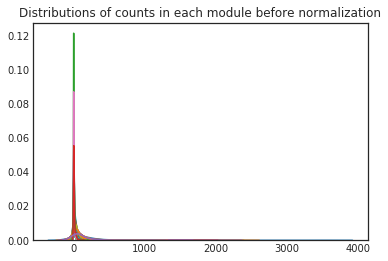

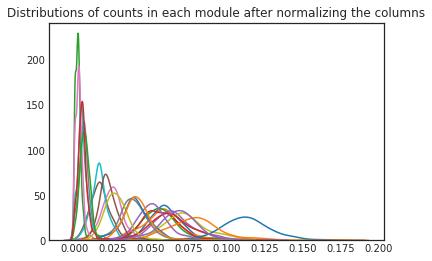

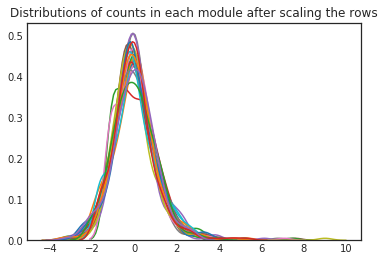

In [15]:
plt.figure()
for rowi,row in bla_table.iterrows():
    sns.kdeplot(row.values)
plt.title('Distributions of counts in each module before normalization')
plt.show()

# We divide each count with the sum for each TF,
# to normalize for TF promiscuity
bla_toplot = (bla_table.loc[:,allfams]/bla_table.loc[:,allfams].sum())

plt.figure()
for rowi,row in bla_toplot.iterrows():
    sns.kdeplot(row.values)
plt.title('Distributions of counts in each module after normalizing the columns')
plt.show()

# then scale the rows to normalize for module size
bla_toplot.loc[:,:] = scale(bla_toplot, axis=1)

plt.figure()
for rowi,row in bla_toplot.iterrows():
    sns.kdeplot(row.values)
plt.title('Distributions of counts in each module after scaling the rows')
plt.show()

dan_toplot =  (dan_table.loc[:,allfams]/dan_table.loc[:,allfams].sum())
dan_toplot.loc[:,:] = scale(dan_toplot, axis=1)      

We can now directly compare modules between the two species.     
We compute pairwise correlations next:

In [16]:
# Get euclidean distances for each pair of modules in a table:
dists =  pd.DataFrame( PWD(dan_toplot,bla_toplot, metric="correlation") )
dists.columns = bla_toplot.index
dists.index = dan_toplot.index

dists.head(3)

,32 cells,N.tube(neurotrans.),Gills,N.tube(neurogen.),Ovary/ Testis(translation),Cilium,Muscle,8-36hpf embryo/ Skin/ Cirri(memb. synt.),"8hpf embryo(transcription, spliceosome)",36hpf embryo,...,Immune,Ovary/ Eggs,Gut,Gut/ Hepatic,Proteasome,PreMet.larvae,Cirri(memb. synt.),Hepatic,Gills/ PreMet larvae,Mitochondrion
larvae 7d melanin,1.151380,0.947201,0.913505,0.887989,0.953334,1.158688,0.864133,0.908501,1.182973,0.849711,...,1.094687,1.124850,1.108710,1.062467,1.005558,0.941354,1.047911,1.116202,1.108350,0.949150
Ovary/ Sperm,0.937669,1.057291,1.042298,1.137438,1.037023,0.876615,1.071010,0.988779,0.872905,1.048430,...,1.018499,0.873161,0.889911,0.969410,1.152619,1.105972,1.006390,0.916814,0.931047,0.983802
Brain,1.054350,0.729294,0.885493,0.669514,1.079856,1.125982,0.798176,1.101103,1.055849,0.861110,...,1.044327,1.087449,1.142921,1.124648,0.918456,0.822229,0.942510,1.051548,0.959279,1.092851


## The final plot:

We can now directly visualize the table with the correlations.    
We will use the clustering we got for the gene-based table earlier:

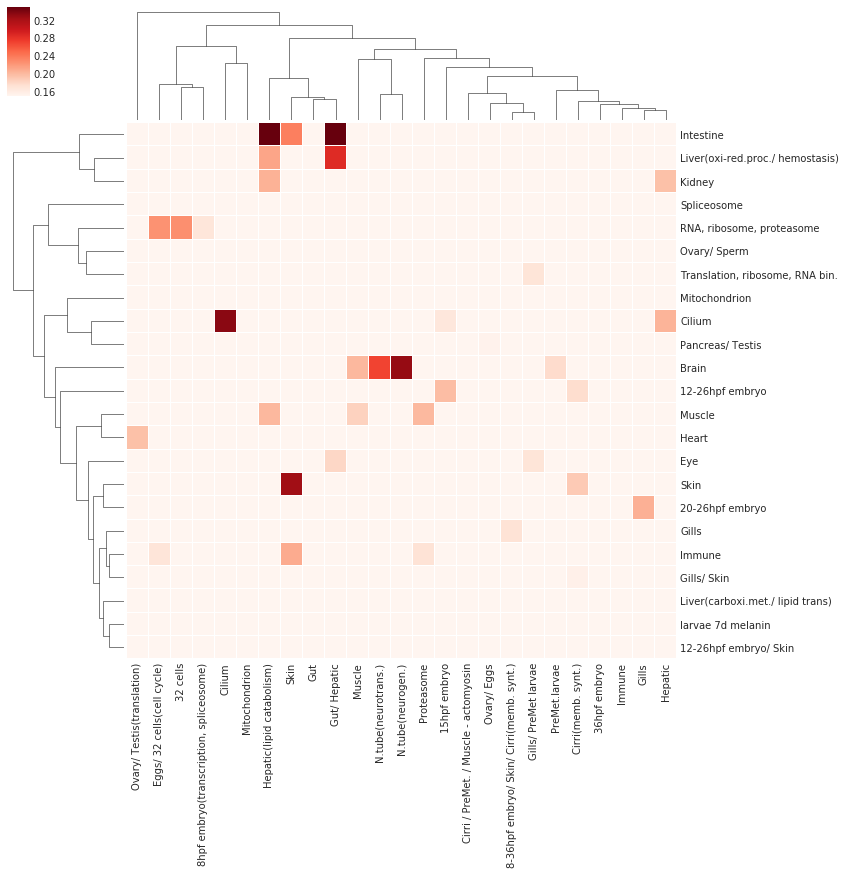

In [17]:
# we can now visualize the TF-based distances
# we'll use the clustering from the gene-based comparison

cg = sns.clustermap( 1-dists, 
                    
                    # The previously computed clustering
                    row_linkage=linkage_HG_rows, 
                    col_linkage=linkage_HG_cols,
                    
                    linewidths=0.01,
                    figsize =(12,12),
                    
                    vmax=0.35,
                    vmin=0.15,
                    cmap = 'Reds'
                   )

_ = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

### PWM z-scores plots

In [19]:
def RBOscore(l1, l2, p = 0.98):
    # https://github.com/ragrawal/measures/blob/master/measures/rankedlist/RBO.py

    """
        Calculates Ranked Biased Overlap (RBO) score. 
        l1 -- Ranked List 1
        l2 -- Ranked List 2
    """
#     if l1 == None: l1 = []
#     if l2 == None: l2 = []
    
    sl,ll = sorted([(len(l1), l1),(len(l2),l2)], key=lambda x: x[0])
    s, S = sl
    l, L = ll
    if s == 0: return 0

    # Calculate the overlaps at ranks 1 through l 
    # (the longer of the two lists)
    ss = set([]) # contains elements from the smaller list till depth i
    ls = set([]) # contains elements from the longer list till depth i
    x_d = {0: 0}
    sum1 = 0.0
    for i in range(l):
        x = L[i]
        y = S[i] if i < s else None
        d = i + 1
        
        # if two elements are same then 
        # we don't need to add to either of the set
        if x == y: 
            x_d[d] = x_d[d-1] + 1.0
        # else add items to respective list
        # and calculate overlap
        else: 
            ls.add(x) 
            if y != None: ss.add(y)
            x_d[d] = x_d[d-1] + (1.0 if x in ss else 0.0) + (1.0 if y in ls else 0.0)     
        #calculate average overlap
        sum1 += x_d[d]/d * pow(p, d)
        
    sum2 = 0.0
    for i in range(l-s):
        d = s+i+1
        sum2 += x_d[d]*(d-s)/(d*s)*pow(p,d)

    sum3 = ((x_d[l]-x_d[s])/l+x_d[s]/s)*pow(p,l)

    # Equation 32
    rbo_ext = (1-p)/p*(sum1+sum2)+sum3
    return rbo_ext

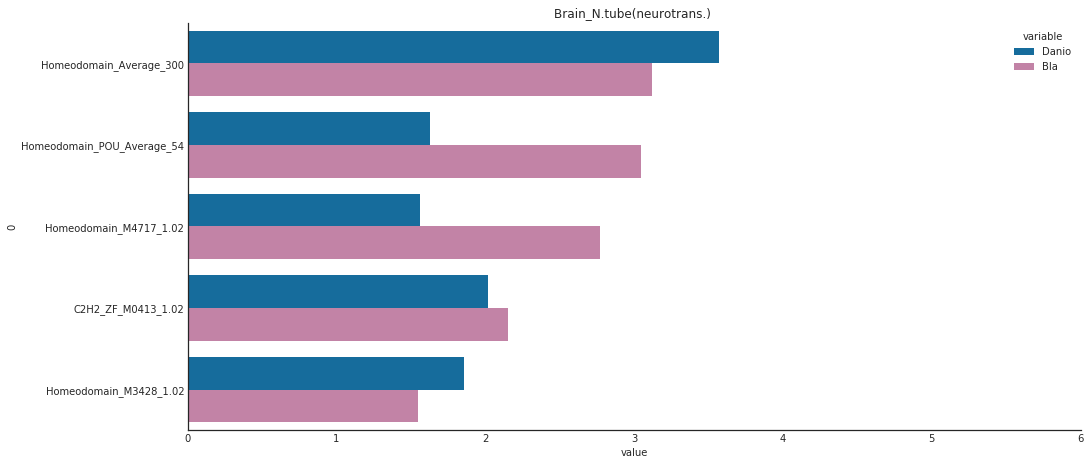

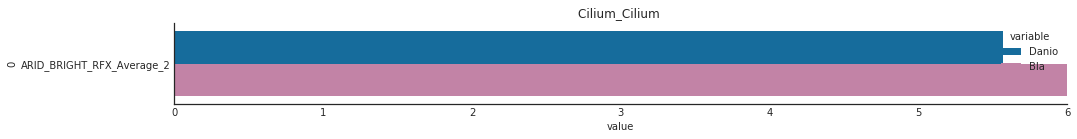

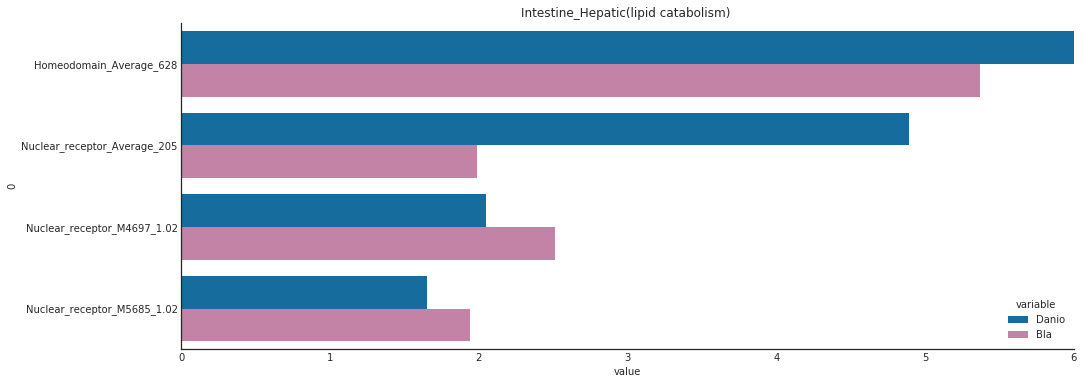

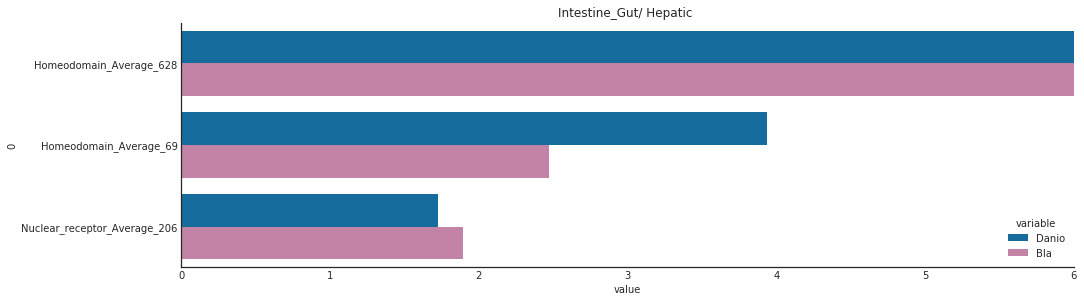

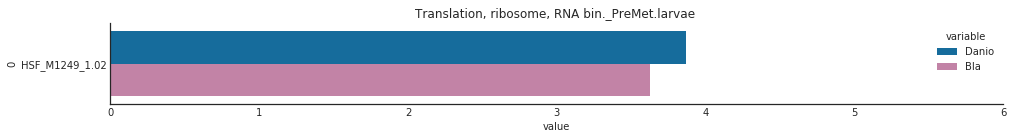

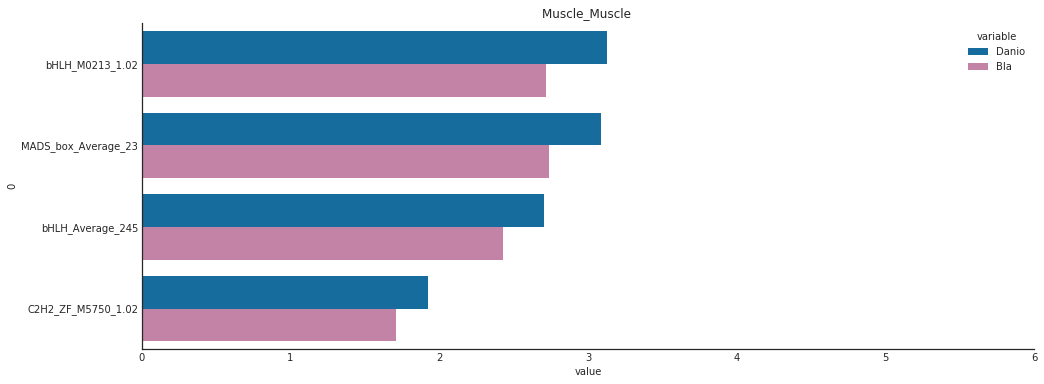

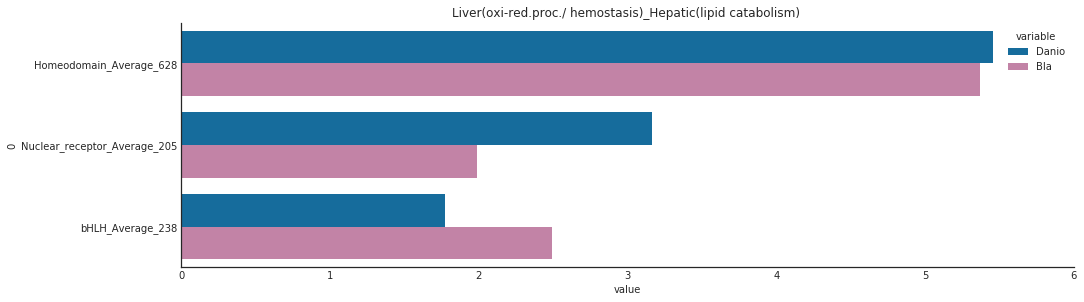

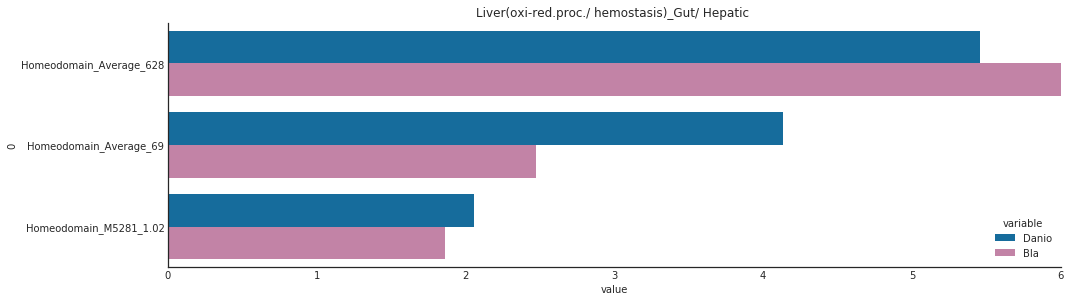

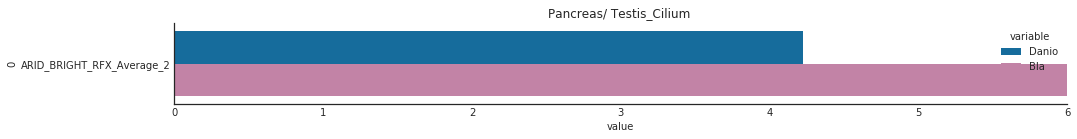

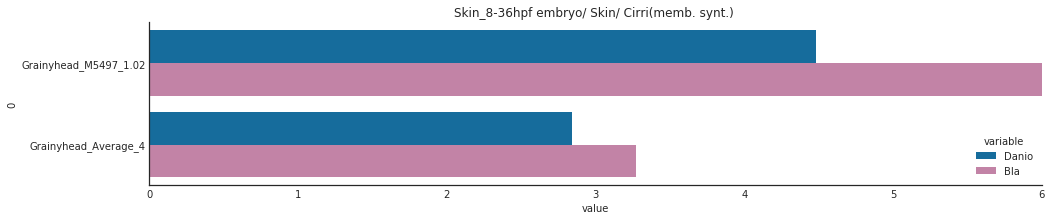

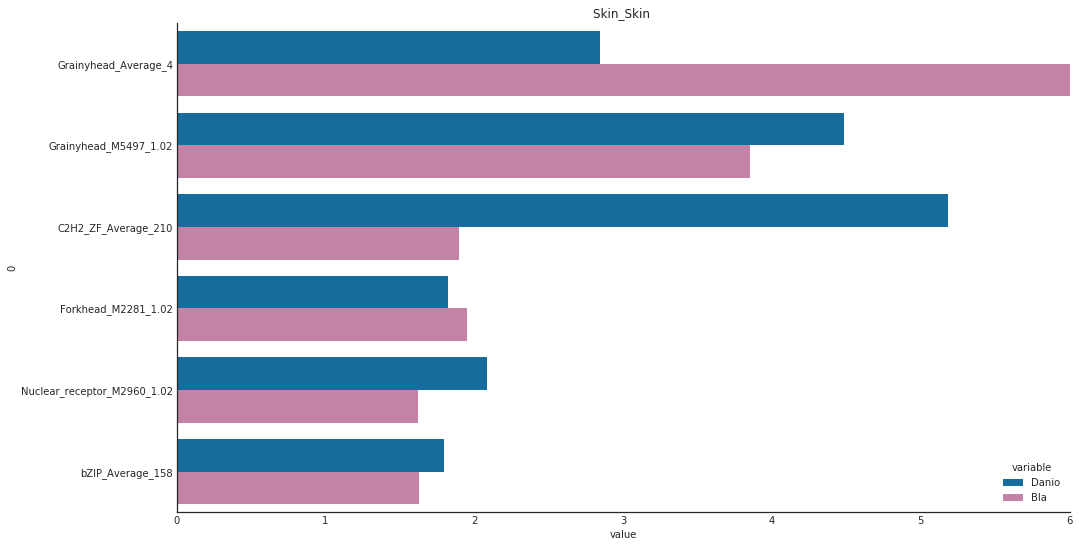

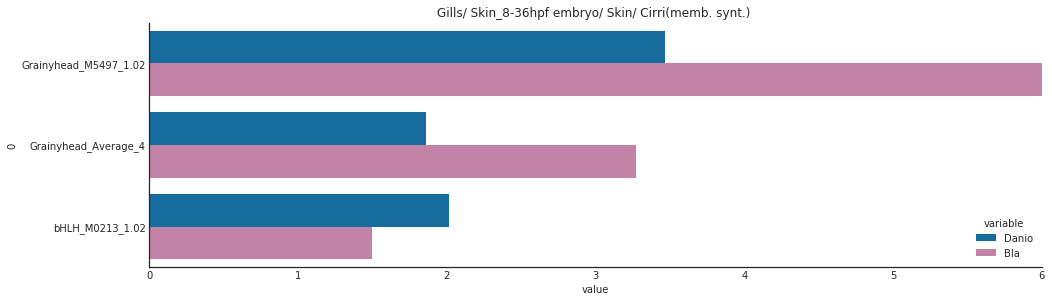

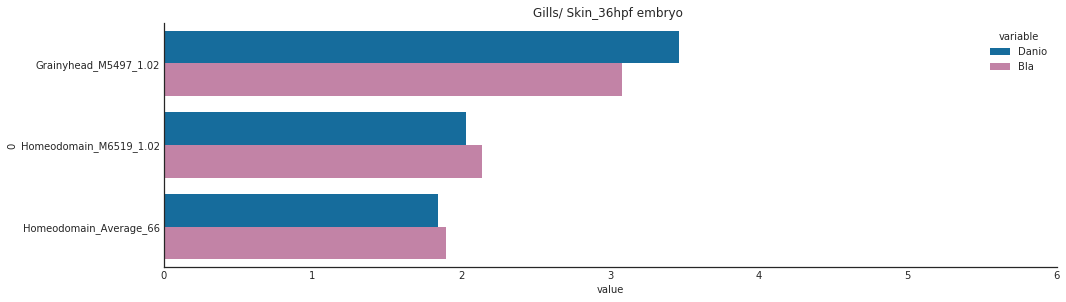

In [20]:
# Select some interesting cases and plot the RBOscore for those TFs in both species:
for drown, drow in dan_toplot.iterrows():
    for brown, brow in bla_toplot.iterrows():
        ld = drow.sort_values(ascending=False).index.values
        lb = brow.sort_values(ascending=False).index.values
        rbo = RBOscore(ld,lb, 0.85)
        if rbo >0.25:
            
            
            d = dan_toplot.loc[drown,:].sort_values(ascending=False)
            dset = set(d[d>1.5].index.values)

            b = bla_toplot.loc[brown,:].sort_values(ascending=False)
            bset = set(b[b>1.5].index.values)

            gset = dset.intersection(bset)

            gee = SF.loc[gset].drop_duplicates(subset=2).copy()

            gee['Danio'] = gee.index.to_series().map(d.loc[gset])
            gee['Bla'] = gee.index.to_series().map(b.loc[gset])


            tp = gee[[0,'Danio','Bla']]
            
            plt.figure(figsize=(16,1.5*len(gset)))
            order = tp.loc[tp.sum( axis=1).sort_values(ascending=False).index,0].values
            
            sns.barplot(data=pd.melt(tp,id_vars=0), x='value',y=0, hue='variable', order=order,
                       palette={'Danio':'#0072b2','Bla':'#cc79a7'})
            
            title = "{}_{} ".format(drown, brown)
            plt.title(title)
            sns.despine()
            plt.xlim((0,6))
            
            plt.show()

In [5]:
transA = {
'black' : '32 cells',
'blue' : 'N.tube(neurotrans.)',
'brown' : 'Gills',
'cyan' : 'N.tube(neurogen.)',
'darkmagenta' : 'Ovary/ Testis(translation)',
'darkorange' : 'Cilium',
'darkred' : 'Muscle',
'darkseagreen4' : '8-36hpf embryo/ Skin/ Cirri(memb. synt.)',
'darkslateblue' : '8hpf embryo(transcription, spliceosome)',
'darkturquoise' : '36hpf embryo',
'green' : 'Eggs/ 32 cells(cell cycle)',
'greenyellow' : 'Hepatic(lipid catabolism)',
'lavenderblush3' : 'Cirri / PreMet. / Muscle - actomyosin',
'lightpink4' : '15hpf embryo',
'magenta' : 'Skin',
'navajowhite2' : 'Immune',
'palevioletred3' : 'Ovary/ Eggs',
'pink' : 'Gut',
'plum1' : 'Gut/ Hepatic',
'plum2' : 'Proteasome',
'red' : 'PreMet.larvae',
'salmon' : 'Cirri(memb. synt.)',
'sienna3' : 'Hepatic',
'thistle2' : 'Gills/ PreMet larvae',
'turquoise' : 'Mitochondrion'}
transZ = {
 'bisque4' : "larvae 7d melanin",
'black' : "Ovary/ Sperm",
'blue' : "Brain",
'brown' : "Cilium",
'brown4' : "Liver(carboxi.met./ lipid trans)",
'coral2' : "Mitochondrion",
'darkgreen' : "Intestine",
'darkgrey' : "RNA, ribosome, proteasome",
'darkmagenta' : "Translation, ribosome, RNA bin.",
'darkorange' : "Muscle",
'darkred' : "Liver(oxi-red.proc./ hemostasis)",
'darkseagreen4' : "12-26hpf embryo/ Skin",
'darkslateblue' : "Immune",
'green' : "Spliceosome",
'honeydew1' : "12-26hpf embryo",
'ivory' : "Eye",
'lightcyan' : "Heart",
'lightgreen' : "Pancreas/ Testis",
'magenta' : "Gills",
'pink' : "Skin",
    
'salmon' : "20-26hpf embryo",
'yellow4' : "Kidney",
'yellowgreen' : "Gills/ Skin"}

transA_sh = {
'black' : 'a-32cells',
'blue' : 'a-n.tube-syna',
'brown' : 'a-gills',
'cyan' : 'a-n.tube-neuro',
'darkmagenta' : 'a-ov.tes.-transl',
'darkorange' : 'a-cilium',
'darkred' : 'a-muscle',
'darkseagreen4' : 'a-emb.8-36',
'darkslateblue' : 'a-embr.8-spli.',
'darkturquoise' : 'a-embryo 36',
'green' : 'a-egg-32cells',
'greenyellow' : 'a-hepa.-lipid',
'lavenderblush3' : 'a-actomyos',
'lightpink4' : 'a-embr.15',
'magenta' : 'a-skin',
'navajowhite2' : 'Immune',
'palevioletred3' : 'a-ovary-egg',
'pink' : 'a-gut',
'plum1' : 'a-gut-hepa.',
'plum2' : 'a-proteasome',
'red' : 'a-pm larvae',
'salmon' : 'a-cirri (memb.)',
'sienna3' : 'a-hepatic',
'thistle2' : 'a-gills-pm larv.',
'turquoise' : 'Mitochondrion'}
transZ_sh = {
 'bisque4' : "z-larv7d-mel",
'black' : "z-ovary-sperm",
'blue' : "z-brain",
'brown' : "z-cilium",
'brown4' : "z-liver b",
'coral2' : "Mitochondrion",
'darkgreen' : "z-intestine",
'darkgrey' : "z-ribo.-proteas",
'darkmagenta' : "z-translation",
'darkorange' : "z-muscle",
'darkred' : "z-liver a",
'darkseagreen4' : "z-embr.12-26",
'darkslateblue' : "Immune",
'green' : "z-splicing",
'honeydew1' : "z-emb12-26-skn",
'ivory' : "z-eye",
'lightcyan' : "z-heart",
'lightgreen' : "z-panc.-testis",
'magenta' : "z-gills",
'pink' : "z-skin",
'salmon' : "z-emb.20-26",
'yellow4' : "z-kidney",
'yellowgreen' : "z-gills early"}